# Facial Expression Recognition using CNNs and Transfer Learning
This notebook demonstrates how to fine-tune a pre-trained VGG16 model for facial expression recognition.

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 2. Prepare the Facial Expression Dataset
Assume the dataset is organized in subfolders per class under 'data/facial_expressions/'.

In [2]:
# Set dataset path to the new face_data directory
base_dir = 'face_data/train'  # Update this path if your dataset is elsewhere

# Image parameters
img_size = 48
batch_size = 32

# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
print(f"Classes: {class_labels}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 5741 images belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 3. Build and Fine-tune the VGG16 Model

In [3]:
# Load VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze all layers initially

# Add custom layers
inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 4. Train the Model (Feature Extraction)

In [8]:
# Update num_classes based on the dataset
num_classes = train_generator.num_classes

# Rebuild the model with the correct number of classes
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train only the custom layers (faster training)
history = model.fit(
    train_generator,
    epochs=15,              # Increased epochs for better learning
    steps_per_epoch = 50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2194 - loss: 1.9429

c:\Users\shrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 640ms/step - accuracy: 0.2196 - loss: 1.9418 - val_accuracy: 0.2831 - val_loss: 1.7751
Epoch 2/15
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2545 - loss: 1.7943

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.2545 - loss: 1.7940 - val_accuracy: 0.2867 - val_loss: 1.7504
Epoch 3/15
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.2857 - loss: 1.7536

50/50 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.2854 - loss: 1.7538 - val_accuracy: 0.2883 - val_loss: 1.7393
Epoch 4/15
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.2536 - loss: 1.7894

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2537 - loss: 1.7891 - val_accuracy: 0.3012 - val_loss: 1.7271
Epoch 5/15
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2878 - loss: 1.7675

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 601ms/step - accuracy: 0.2878 - loss: 1.7673 - val_accuracy: 0.3019 - val_loss: 1.7261
Epoch 6/15
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2988 - loss: 1.7324

50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 620ms/step - accuracy: 0.2987 - loss: 1.7326 - val_accuracy: 0.3153 - val_loss: 1.7170
Epoch 7/15
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2864 - loss: 1.7372

50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.2865 - loss: 1.7373 - val_accuracy: 0.3120 - val_loss: 1.7119
Epoch 8/15
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2642 - loss: 1.7346

50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 575ms/step - accuracy: 0.2642 - loss: 1.7348 - val_accuracy: 0.3182 - val_loss: 1.7109
Epoch 9/15
Epoch 9/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.3101 - loss: 1.7331 - val_accuracy: 0.3099 - val_loss: 1.7132
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 571ms/step - accuracy: 0.3101 - loss: 1.7331 - val_accuracy: 0.3099 - val_loss: 1.7132
Epoch 10/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 576ms/step - accuracy: 0.2928 - loss: 1.7371 - val_accuracy: 0.3069 - val_loss: 1.7122
Epoch 11/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 576ms/step - accuracy: 0.2928 - loss: 1.7371 - val_accuracy: 0.3069 - val_loss: 1.7122
Epoch 11/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3212 - loss: 1.7054

50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 577ms/step - accuracy: 0.3209 - loss: 1.7057 - val_accuracy: 0.3155 - val_loss: 1.7063
Epoch 12/15
Epoch 12/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 577ms/step - accuracy: 0.3227 - loss: 1.7187 - val_accuracy: 0.3088 - val_loss: 1.7156
Epoch 13/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 577ms/step - accuracy: 0.3227 - loss: 1.7187 - val_accuracy: 0.3088 - val_loss: 1.7156
Epoch 13/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2874 - loss: 1.7201

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 620ms/step - accuracy: 0.2875 - loss: 1.7201 - val_accuracy: 0.3195 - val_loss: 1.7022
Epoch 14/15
Epoch 14/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3004 - loss: 1.7189 - val_accuracy: 0.3195 - val_loss: 1.7022
Epoch 15/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.3004 - loss: 1.7189 - val_accuracy: 0.3195 - val_loss: 1.7022
Epoch 15/15
18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.2830 - loss: 1.7158

c:\Users\shrey\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.2952 - loss: 1.7233 - val_accuracy: 0.3242 - val_loss: 1.6980


## 5. Fine-tune the Model (Unfreeze Some Layers)

In [10]:
# Unfreeze the last few layers of VGG16 for fine-tuning
for layer in base_model.layers[-8:]:  # Unfreeze more layers for better learning
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=5e-5),  # Slightly lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=5,                # Increased epochs for better fine-tuning
    steps_per_epoch = 50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 756ms/step - accuracy: 0.2641 - loss: 1.8159 - val_accuracy: 0.2937 - val_loss: 1.7446
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 756ms/step - accuracy: 0.2641 - loss: 1.8159 - val_accuracy: 0.2937 - val_loss: 1.7446
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3120 - loss: 1.7283

KeyboardInterrupt: 

## 6. Improved Fine-tuning with Callbacks

In [ ]:
# Unfreeze more layers for better fine-tuning
for layer in base_model.layers[-16:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history_finetune = model.fit(
    train_generator,
    epochs=15,                # More epochs for better accuracy
    steps_per_epoch = 50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.3716 - loss: 1.6520

KeyboardInterrupt: 

180/180 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.3128 - loss: 1.7022
180/180 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.3128 - loss: 1.7022
Validation accuracy: 0.3202
Error: 'history_finetune' is not defined. Ensure that the fine-tuning process has been executed.
Validation accuracy: 0.3202
Error: 'history_finetune' is not defined. Ensure that the fine-tuning process has been executed.


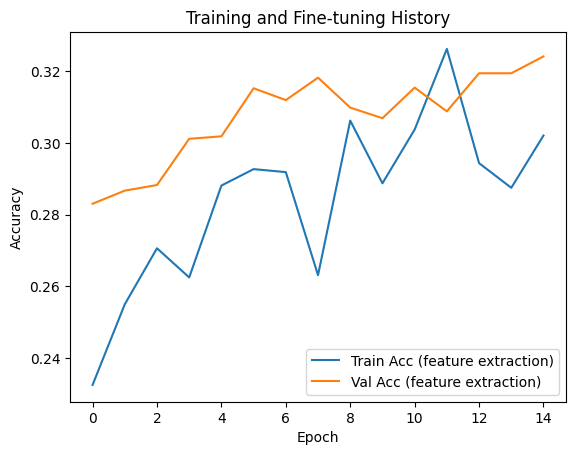

In [12]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation accuracy: {val_acc:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Acc (feature extraction)')
plt.plot(history.history['val_accuracy'], label='Val Acc (feature extraction)')
if 'history_finetune' in globals():
    plt.plot(np.arange(len(history_finetune.history['accuracy'])) + len(history.history['accuracy']),
             history_finetune.history['accuracy'], label='Train Acc (fine-tune)')
    plt.plot(np.arange(len(history_finetune.history['val_accuracy'])) + len(history.history['val_accuracy']),
             history_finetune.history['val_accuracy'], label='Val Acc (fine-tune)')
else:
    print("Error: 'history_finetune' is not defined. Ensure that the fine-tuning process has been executed.")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Fine-tuning History')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


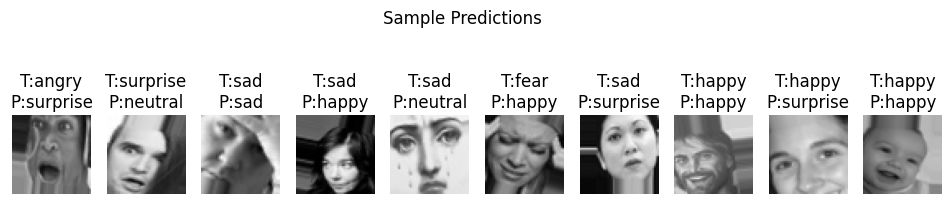

In [13]:
# Ensure class_labels is populated and matches the generator
images, labels = next(val_generator)  # Get a batch of validation images and labels
if not class_labels or len(class_labels) != labels.shape[1]:
    class_labels = list(val_generator.class_indices.keys())

# Get a batch of validation images and labels
images, labels = next(val_generator)
preds = model.predict(images)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(labels, axis=1)

plt.figure(figsize=(12, 3))
num_images = min(len(images), 10)
for i in range(num_images):
    t_idx = true_labels[i]
    p_idx = pred_labels[i]
    t_label = class_labels[t_idx] if t_idx < len(class_labels) else str(t_idx)
    p_label = class_labels[p_idx] if p_idx < len(class_labels) else str(p_idx)
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.title(f"T:{t_label}\nP:{p_label}")
    plt.axis('off')
plt.suptitle('Sample Predictions')
plt.show()

In [14]:
# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(1)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (img_size, img_size))
        face_img = face_img.astype('float32') / 255.0
        face_img = np.expand_dims(face_img, axis=0)
        pred = model.predict(face_img)
        pred_label = class_labels[np.argmax(pred)]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, pred_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.imshow('Facial Expression Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━

KeyboardInterrupt: 

**Note:**
- Press 'q' to quit the webcam window.
- Make sure you have `opencv-python` installed (`pip install opencv-python`).
- Good lighting and a clear face will improve detection and prediction.